In [167]:
# from sklearn.model_selection import StratifiedShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from pycocotools.coco import COCO

In [168]:
data_type = 'train' 

src_root = '/opt/ml/finalproject/data/' + data_type
src_file = os.path.join(src_root, 'full_train.json')

coco_obj = COCO(src_file)

loading annotations into memory...
Done (t=5.25s)
creating index...
index created!


In [169]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

In [170]:
img_id = coco_obj.getImgIds()
print(len(img_id), img_id[-1])

137415 137414


In [171]:
import numpy as np
li = [0]*38
X = [i for i in range(len(img_id))]
y = []
img_id = coco_obj.getImgIds()
for img in img_id:
    ann_id = coco_obj.getAnnIds(imgIds=img)
    one_hot = li.copy()
    for ann in ann_id:
        annotation = coco_obj.loadAnns(ann)
        cat_id = annotation[0]['category_id']
        one_hot[cat_id] = 1
    y.append(one_hot)
    
X = np.array(X)
y = np.array(y)

In [172]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [173]:
for train_index, test_index in mskf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

TRAIN: [     0      2      3 ... 137411 137412 137413] TEST: [     1      5     12 ... 137402 137406 137414]


In [174]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

110130 27285
110130 27285


In [175]:
train_img = []
train_ann = []
for idx, image_id in enumerate(X_train):
    img_anno = coco_obj.loadImgs(int(image_id))
    img_anno[0]['id'] = idx
    train_img.append(img_anno[0])
    ann_ids = coco_obj.getAnnIds(image_id)
    for ann_id in ann_ids:
        ann = coco_obj.loadAnns(ann_id)[0]
        ann['image_id'] = idx
        train_ann.append(ann)
    
test_img = []
test_ann = []
for idx, image_id in enumerate(X_test):
    img_anno = coco_obj.loadImgs(int(image_id))
    img_anno[0]['id'] = idx
    test_img.append(img_anno[0])
    ann_ids = coco_obj.getAnnIds(image_id)
    for ann_id in ann_ids:
        ann = coco_obj.loadAnns(ann_id)[0]
        ann['image_id'] = idx
        test_ann.append(ann)

In [176]:
train_json = root.copy()
test_json = root.copy()

train_json['images'] = train_img
train_json['annotations'] = train_ann
test_json['images'] = test_img
test_json['annotations'] = test_ann

In [177]:
with open("train.json", "w") as f:
    json.dump(train_json, f)
    
with open("test.json", "w") as f:
    json.dump(test_json, f)

# 데이터 시각화

In [193]:
# Reading the json file
src_file = "test.json"
coco_obj = COCO(src_file)
with open(src_file, 'r') as f:
    root = json.load(f)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


In [194]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]

print('Dataset Name: ',"new_eval")
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Dataset Name:  new_eval
Number of images:  27285
Number of bounding boxes:  75151
Number of classes:  38
Max min avg height:  647 48 432
Max min avg width:  1426 66 573


    id                           name  count
9   15                        Lighter   6465
6   28           SupplymentaryBattery   6353
22  24                     SmartPhone   6177
4   13                          Knife   5927
2   22                       Scissors   4314
15  21                            Saw   3371
7    8                            Gun   2846
10  34                         Chisel   2842
5   26                        Spanner   2842
23  31                            USB   2655
21  12                            HDD   2509
27   7                    Firecracker   2325
26   9                       GunParts   2286
1    3                            Axe   2260
16  10                         Hammer   2168
11  23                    Screwdriver   2102
3   33                          Plier   1837
24   2                            Awl   1569
19  18                      MetalPipe   1422
33  16                         Liquid   1419
32   6                         Bullet   1363
25  19    

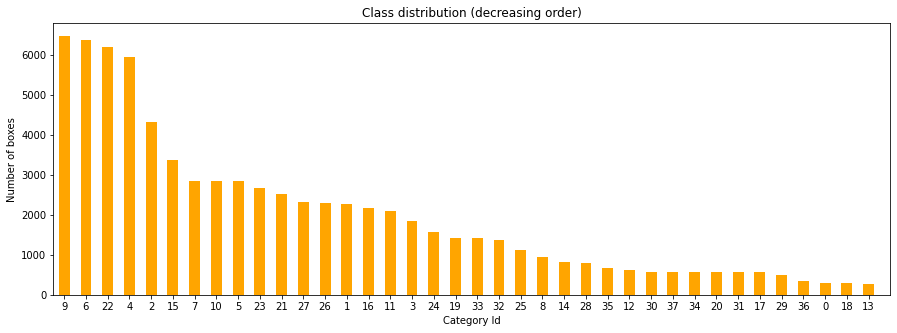

75151


In [195]:
# Class distribution
cat = {x['id']: x['name'] for x in root['categories']}
# print(list(cat.values())[30:])
df = pd.DataFrame(list(cat.items()), columns=['id', 'name']) #.set_index('id')

count = []
for i in coco_obj.getCatIds():
    count.append(len(coco_obj.getAnnIds(catIds=i)))
df['count'] = count

df = df.sort_values(by='count', ascending=False)
print(df)

print(len(df['name']))

# # to plot
y = list(df['count'])
x = list(df.index)

plt.figure(figsize=(15,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()

print(df["count"].sum())

no obejct image number:  0
{5: 5019, 6: 758, 4: 4514, 3: 1067, 2: 7801, 1: 8039, 7: 86, 8: 1}


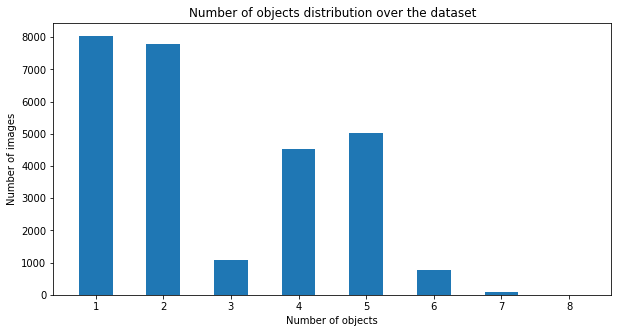

Number of images having atleast one box:  8
Min number of boxes per image:  1
Max number of boxes per image:  8039
Avg number of boxes per image:  3410


In [196]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

no_object_list = []
for i in root['images']:
    a = coco_obj.getAnnIds(imgIds=i['id'])
    img2nboxes.setdefault(len(a), 0)
    img2nboxes[len(a)] += 1

    if len(a) == 0:
        file_path = i["path"]
        file_name = i["file_name"]
        file_path = file_path.split('/')
        del file_path[2]
        file_path = '/'.join(file_path)

        path = os.path.join(file_path[1:], file_name)
        
        no_object_list.append(path)

print('no obejct image number: ',len(no_object_list))
# print(no_object_list)

if len(no_object_list)>10:
    no_object_list = no_object_list[:10]

# 객체 없는 이미지 출력        
if no_object_list:
    n_rows = 1
    n_cols = len(no_object_list)
    fig = plt.figure(figsize=(20,10))
    for i, img_path in enumerate(no_object_list):
        image = Image.open(os.path.join('/opt/ml/finalproject/data/train',img_path))
        ax = fig.add_subplot(1,len(no_object_list), i+1)
        # ax.set_title(img_path, fontsize = 10)
        plt.axis('off')
        plt.imshow(image)
    # plt.tight_layout()
    plt.show()

# print(img2nboxes)

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

print(img2nboxes)

plt.figure(figsize=(10,5))
plt.bar(list(img2nboxes.keys()), list(img2nboxes.values()), tick_label=[str(i) for i in img2nboxes.keys()], width=0.5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show() 

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

In [197]:
img_id = coco_obj.getImgIds()

multi_origin = []
multi_other = []
single_origin = []
single_other = []

img_num = len(img_id)

for i in img_id:
    path = root['images'][i-1]['path']
    a = path.split('/')
    # a = path.split("\\")
    # print(a)
    # category = a[2]
    # sub_cat = a[3]
    category = a[3]
    sub_cat = a[4]
    # print(category, sub_cat)
    
    if sub_cat == 'Multiple_Categories':
        multi_origin.append(category)
    elif sub_cat == "Multiple_Other":
        multi_other.append(category)
    elif sub_cat == "Single_Default":
        single_origin.append(category)
    else:
        single_other.append(category)
    

In [198]:
li = [multi_origin, multi_other, single_origin, single_other]
for d in li:
    # print(len(d))
    print(len(d)/img_num)
    
print(df["count"].sum())

0.4069268829026938
0.2986256184716877
0.14700384826827928
0.1474436503573392
75151
